In [1]:
# 1. Load pretrained model
# 2. Load query embeddings
# 3. Compute corpus output from query embeddings
# 4. Concatenate original embeddings with corpus embeddings 
# 5. Add the new numpy array to Flatindex
# 6. Find n nearest queries of a passage
# 7. Compare with the groud truth

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_HIDDEN_NODES = 64
NUM_HIDDEN_LAYERS = 3
DROPOUT_RATE = 0.1
FEAT_COUNT = 768


# Define the network
class CorpusNet(torch.nn.Module):

    def __init__(self, embed_size):
        super(CorpusNet, self).__init__()

        layers = []
        last_dim = FEAT_COUNT
        for i in range(NUM_HIDDEN_LAYERS):
            layers.append(nn.Linear(last_dim, NUM_HIDDEN_NODES))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(NUM_HIDDEN_NODES))
            layers.append(nn.Dropout(p=DROPOUT_RATE))
            last_dim = NUM_HIDDEN_NODES
        layers.append(nn.Linear(last_dim, embed_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def parameter_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [417]:
import pickle
import numpy as np

PASSAGE_NP_PATH = "/home/jianx/results/passage_0__emb_p__data_obj_0.pb"
PASSAGE_MAP_PATH = "/datadrive/jianx/data/annoy/100_ance_passage_map.dict"
QUERY_TRAIN_NP_PATH = "/home/jianx/results/query_0__emb_p__data_obj_0.pb"
QUERY_TEST_NP_PATH = "/home/jianx/results/test_query_0__emb_p__data_obj_0.pb"
QUERY_MAP_PATH = "/datadrive/jianx/data/annoy/100_ance_query_train_map.dict"
# REVERSE_RANKER_PATH = "/home/ruohan/DSSM/search-exposure/reverse_ranker/results/reverse_fine_tune1000_100_1000_0.0001_32.model"
# REVERSE_RANKER_PATH = "/home/ruohan/DSSM/search-exposure/reverse_ranker/results/reverse_new_training1000_100_1000_0.0001_32.model"
REVERSE_RANKER_PATH = "/datadrive/ruohan/results/reverse_embed32_alpha0.5_combine_train_data1000_100_1000_0.0005_32.model"


CURRENT_DEVICE = "cuda:1"
EMBED_SIZE = 32

def obj_reader(path):
    with open(path, 'rb') as handle:
        return pickle.load(handle, encoding="bytes")

# 1. Load pretrained model
reverse_ranker = CorpusNet(embed_size=EMBED_SIZE)
reverse_ranker.load_state_dict(torch.load(REVERSE_RANKER_PATH))
reverse_ranker.to(CURRENT_DEVICE)
reverse_ranker.eval()


CorpusNet(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
  )
)

In [295]:
# 2. Load query embeddings
passage_np = obj_reader(PASSAGE_NP_PATH)
pid_mapping = obj_reader(PASSAGE_MAP_PATH)
query_np = obj_reader(QUERY_TRAIN_NP_PATH)
qid_mapping = obj_reader(QUERY_MAP_PATH)

In [363]:
test_query_np = obj_reader(QUERY_TEST_NP_PATH)

In [296]:
pid_reverse_mapping = {v: k for k, v in pid_mapping.items()}
qid_reverse_mapping = {v: k for k, v in qid_mapping.items()}

In [5]:
# Load ground truth ranking
TRUE_PATH = "/datadrive/jianx/data/results/all_search_rankings_100_100_flat.csv"
def load_true_dict(k = 100, path = TRUE_PATH):
    true_dict = {}
    with open(path, "r") as file:
        for line in file:
            qid = int(line.split(",")[0])
            pid = int(line.split(",")[1])
            rank = int(line.split(",")[2])
            if rank > k:
                continue
            if pid not in true_dict.keys():
                true_dict[pid] = {}
            true_dict[pid][qid] = rank
    return true_dict
def load_forward_dict(k = 100, path = TRUE_PATH):
    true_dict = {}
    with open(path, "r") as file:
        for line in file:
            qid = int(line.split(",")[0])
            pid = int(line.split(",")[1])
            rank = int(line.split(",")[2])
            if rank > k:
                continue
            if qid not in true_dict.keys():
                true_dict[qid] = {}
            true_dict[qid][pid] = rank
    return true_dict

In [6]:
forward_dict_100 = load_forward_dict(k=100)
true_dict_100 = load_true_dict(k=100)

In [7]:
# 3. Compute corpus output from query embeddings
# 4. Concatenate original embeddings with corpus embeddings 

In [372]:
def transform_np(query_np, b=100):
    n = int(query_np.shape[0]/b) + 1

    corpus_output = []
    for i in range(n):
        start = i * b
        end = (i + 1) * b
        if i == n-1:
            end = query_np.shape[0]
        q_embed = query_np[start:end,:]
        q_embed = torch.from_numpy(q_embed).to(CURRENT_DEVICE)
        corpus_output.append(reverse_ranker(q_embed).detach().cpu().numpy())
    corpus_np = np.concatenate(corpus_output[:-1])
    corpus_np = np.concatenate((corpus_np, corpus_output[-1]))
    query_new_np = np.concatenate((corpus_np, query_np), axis=1)
    print(query_new_np.shape)
    return query_new_np

In [373]:
def generate_new_np(query_np, passage_np, normalize=True):
    query_new_np = transform_np(query_np)
    passage_new_np = transform_np(passage_np)
    all_new_np = np.concatenate((query_new_np, passage_new_np))
    if normalize:
        all_new_np = F.normalize(torch.from_numpy(all_new_np)).numpy()
    n_query = query_new_np.shape[0]
    query_new_np = all_new_np[:n_query,:]
    passage_new_np = all_new_np[n_query:,:]
    return query_new_np, passage_new_np

In [374]:
# test_query_new_np, _ = generate_new_np(test_query_np, test_query_np, normalize=False)

In [418]:
query_new_np, passage_new_np = generate_new_np(query_np, passage_np, normalize=False)

(502939, 800)
(8841823, 800)


In [324]:
def output_mean_sd(obj, split=785):
    original = obj[:,:split].flatten()
    new = obj[:,split:].flatten()
    return np.mean(original), np.mean(new)

In [335]:
print(output_mean_sd(query_new_np))
print(output_mean_sd(passage_new_np))

(0.0017042127, 0.04944169)
(0.0014752821, 0.046954654)


In [419]:
# 5. Add the new numpy array to Flatindex
import faiss
dim = query_new_np.shape[1]
query_index = faiss.IndexFlatIP(dim)
query_index.add(query_new_np)

In [16]:
# 6. Find n nearest queries of a passage
# 7. Compare with the groud truth
def evaluate_reverse_ranker(pred_rank, true_rank, k = 100):
    top_true = []
    top_pred = []
    for pid, qids in pred_rank.items():
        n_top_true = len(true_rank.get(pid, {}))
        temp_pred = np.fromiter(qids.values(), dtype=int)
        n_top_pred = sum((temp_pred != 0) & (temp_pred <= k))
        top_true.append(n_top_true)
        top_pred.append(n_top_pred)
    return top_true, top_pred

In [71]:
def generate_pred_rank(query_index, true_dict, baseline_dict, passage_embed=passage_new_np, 
                       qid_mapping=qid_mapping, pid_reverse_mapping=pid_reverse_mapping, n=100, k=100):
    pid_list = list(baseline_dict.keys())
    all_results = {}
    for i, pid in enumerate(pid_list):
        if i % 50 == 0:
            print(i)
        if i >= n:
            break
        pid_r = pid_reverse_mapping[pid]
        p_embed = passage_embed[pid_r]
        _, near_qids = query_index.search(np.array([p_embed]), k)
        temp_results = {}
        for qid in near_qids[0]:
            qid = qid_mapping[qid]
            try:
                rank = true_dict[pid][qid]
            except:
                rank = 0
            temp_results[qid] = rank
        all_results[pid] = temp_results
    return all_results

In [489]:
TRAIN_RANK_PATH = "/datadrive/jianx/data/train_data/ance_training_rank100_8841823.csv"
N_PASSAGE = 100
TRAIN_PASSAGE = 200000
def load_train(path, N_PASSAGE = 100, TRAIN_PASSAGE = 200000):
    with open(path) as file:
        my_dict = {}
        count = 0
        for line in file:
            count += 1
            if count <= TRAIN_PASSAGE * 100:
                continue            
            if count > (TRAIN_PASSAGE + N_PASSAGE) * 100:
                break
            tokens = line.split(",")
            pid = int(tokens[0])
            qid = int(tokens[1])
            rank = int(tokens[2].rstrip())
            if pid not in my_dict:
                my_dict[pid] = {}
            my_dict[pid][qid] = rank
    return my_dict


## Test Performance

In [116]:
def compare_with_baseline(query_index, true_dict_100, forward_baseline_rank, n=500):
    pred_rank = generate_pred_rank(query_index, true_dict_100, forward_baseline_rank, n=n)
    top_true, top_pred = evaluate_reverse_ranker(pred_rank, true_dict_100, k = 100)
    print("New model: {}".format(np.mean(top_pred)/np.mean(top_true)))
    top_true_baseline, top_pred_baseline = evaluate_reverse_ranker(forward_baseline_rank, true_dict_100, k = 100)
    print("Baseline model: {}".format(np.mean(top_pred_baseline)/np.mean(top_true_baseline)))
    return top_true, top_pred, top_true_baseline, top_pred_baseline, pred_rank

In [189]:
# Fine tune model with loss 0.08
forward_baseline_rank_test = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 200000)
top_true_test, top_pred_test, top_true_baseline_test, top_pred_baseline_test, pred_rank_test = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_test, n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.8908

In [284]:
# Model trained on new training data (not satisfactory)
forward_baseline_rank_test2 = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 200000)
top_true_test2, top_pred_test2, top_true_baseline_test2, top_pred_baseline_test2, pred_rank_test2 = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_test2, n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.8965

In [397]:
# Model trained on alpha=0.5 embed=32 combined training data from 0.08 loss model
forward_baseline_rank_test3 = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 200000)
top_true_test3, top_pred_test3, top_true_baseline_test3, top_pred_baseline_test3, pred_rank_test3 = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_test3, n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.9255

In [420]:
# training data for next phase of training
# Model trained on alpha=0.5 embed=32 combined training data from 0.08 loss model
forward_baseline_rank_train3 = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 0)
top_true_train3, top_pred_train3, top_true_baseline_train3, top_pred_baseline_train3, pred_rank_train3 = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_train3, n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.9127

In [415]:
forward_baseline_rank_test4 = load_train(TRAIN_RANK_PATH, N_PASSAGE = 500, TRAIN_PASSAGE = 200000)
top_true_test4, top_pred_test4, top_true_baseline_test4, top_pred_baseline_test4, pred_rank_test4 = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_test4, n=500)

0
50
100
150
200
250
300
350
400
450
500
New model: 0.9333840883136658
Baseline model: 0.8668695321414986


In [256]:
# fine tune model with loss 0.08
forward_baseline_rank_train = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 0)
top_true_train, top_pred_train, top_true_baseline_train, top_pred_baseline_train, pred_rank_train = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_train, n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.8793

## Train Performance

In [142]:
def obj_writer(obj, path):
    with open(path, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [436]:
RESULT_PATH = "/datadrive/ruohan/reverse_ranker/new_training/"

In [119]:
forward_baseline_rank_train = load_train(TRAIN_RANK_PATH, N_PASSAGE = 500, TRAIN_PASSAGE = 0)

In [120]:
top_true_train, top_pred_train, top_true_baseline_train, top_pred_baseline_train, pred_rank_train = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_train)

0
50
100
150
200
250
300
350
400
450
500
New model: 0.8972089857045609
Baseline model: 0.8318584070796461


In [410]:
# obj_writer(forward_baseline_rank_test3, RESULT_PATH + "forward_baseline_rank_test.pickle")
# obj_writer(top_true_test3, RESULT_PATH + "top_true_test.pickle")
# obj_writer(top_pred_test3, RESULT_PATH + "top_pred_test.pickle")
# obj_writer(top_true_baseline_test3, RESULT_PATH + "top_true_baseline_test.pickle")
# obj_writer(top_pred_baseline_test3, RESULT_PATH + "top_pred_baseline_test.pickle")
# obj_writer(pred_rank_test3, RESULT_PATH + "pred_rank_test.pickle")

In [140]:
forward_baseline_rank_test1 = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 200000)
top_true_test1, top_pred_test1, top_true_baseline_test1, top_pred_baseline_test1, pred_rank_test1 = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_test1,n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.8699

In [437]:
# obj_writer(forward_baseline_rank_train3, RESULT_PATH + "forward_baseline_rank_train.pickle")
# obj_writer(top_true_train3, RESULT_PATH + "top_true_train.pickle")
# obj_writer(top_pred_train3, RESULT_PATH + "top_pred_train.pickle")
# obj_writer(top_true_baseline_train3, RESULT_PATH + "top_true_baseline_train.pickle")
# obj_writer(top_pred_baseline_train3, RESULT_PATH + "top_pred_baseline_train.pickle")
# obj_writer(pred_rank_train3, RESULT_PATH + "pred_rank_train.pickle")

In [141]:
forward_baseline_rank_train1 = load_train(TRAIN_RANK_PATH, N_PASSAGE = 10000, TRAIN_PASSAGE = 0)
top_true_train1, top_pred_train1, top_true_baseline_train1, top_pred_baseline_train1, pred_rank_train1 = compare_with_baseline(query_index, true_dict_100, forward_baseline_rank_train1, n=10000)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
New model: 0.8553

In [409]:
# torch.save(reverse_ranker.state_dict(), RESULT_PATH + "final_model_after_first_training.model")

In [369]:
# obj_writer(query_new_np, RESULT_PATH + "query_new_np.pickle")
# obj_writer(passage_new_np, RESULT_PATH + "passage_new_np.pickle")
# obj_writer(test_query_new_np, RESULT_PATH + "test_query_new_np.pickle")

In [429]:
top_true_test3[:20]

[16, 1, 3, 19, 2, 2, 3, 10, 1, 5, 10, 53, 4, 3, 12, 16, 1, 13, 2, 3]

In [430]:
top_pred_baseline_test3[:20]

[7, 1, 3, 19, 2, 2, 3, 10, 1, 5, 10, 52, 4, 3, 9, 12, 1, 11, 2, 3]

In [432]:
top_pred_test3[:20]

[10, 1, 3, 19, 2, 2, 3, 10, 1, 5, 10, 53, 4, 3, 11, 13, 1, 13, 2, 3]

In [452]:
top_true_baseline_test3[:9999] == top_true_test3[:9999]

True

In [469]:
np.mean(top_pred_baseline_test3[:-1]) / np.mean(top_true_test3)

0.8511590077267182

In [455]:
print(len(top_pred_baseline_test3), len(top_pred_test3), top_pred_baseline_test3[-1], top_pred_test3[-1])

10001 10000 0 11


In [433]:
top_pred_train3[:20]

[6, 8, 1, 1, 3, 1, 0, 9, 10, 0, 2, 12, 4, 7, 17, 8, 1, 1, 7, 18]

In [434]:
top_pred_baseline_train3[:20]

[6, 8, 1, 1, 3, 1, 0, 8, 8, 0, 1, 12, 4, 7, 16, 8, 1, 1, 7, 17]

In [435]:
top_true_train3[:20]

[7, 10, 1, 1, 3, 1, 0, 9, 10, 0, 2, 12, 4, 7, 17, 8, 1, 1, 7, 19]

In [474]:
len(forward_baseline_rank_train3)

10001

In [151]:
pid = list(pred_rank_test1.keys())[0]
print(pred_rank_test1[pid])
print(forward_baseline_rank_test1[pid])

{936936: 0, 70513: 0, 71691: 99, 71002: 52, 634337: 3, 763319: 0, 95819: 0, 65995: 0, 198927: 0, 638036: 0, 761508: 0, 416960: 0, 172447: 0, 471214: 0, 476027: 41, 77359: 0, 1022143: 0, 86942: 80, 1077609: 0, 838494: 0, 166361: 0, 84516: 0, 414158: 0, 625548: 0, 85370: 0, 70841: 0, 64183: 0, 616111: 0, 66134: 0, 761459: 0, 66463: 55, 404677: 8, 884677: 0, 168620: 0, 1070287: 0, 67585: 0, 416099: 0, 70844: 0, 415965: 71, 894492: 0, 70707: 0, 590621: 71, 772753: 0, 881550: 0, 95384: 0, 629020: 0, 565894: 0, 66470: 0, 67856: 0, 581246: 0, 70552: 0, 586461: 0, 67531: 0, 168486: 0, 65342: 0, 586843: 0, 165145: 0, 165076: 0, 67587: 0, 974184: 0, 72794: 0, 67247: 0, 54478: 0, 973060: 0, 54702: 0, 925642: 0, 1159295: 0, 70583: 0, 181081: 0, 73453: 0, 70679: 0, 584760: 0, 5992: 0, 77710: 0, 1077594: 0, 434346: 0, 439545: 0, 869829: 0, 72747: 0, 640480: 0, 70842: 0, 1004472: 0, 1171233: 0, 507385: 0, 484238: 0, 637324: 0, 581481: 0, 416205: 0, 62401: 0, 641498: 0, 741674: 0, 72569: 0, 173640: 0,

In [158]:
set(list(pred_rank_test1[pid].values())) & set(list(forward_baseline_rank_test1[pid].values()))

{0, 3, 41, 55, 71, 80, 99}

In [173]:
def delete_zeros(myDict):
    out_dict = {key:val for key, val in myDict.items() if val != 0}
    return set(list(out_dict.keys()))

In [186]:
def compare_specific_passage(pred_rank_test1, forward_baseline_rank_test1, n=10000):
    count = 0
    count_loss = 0
    all_count = 0
    all_count_loss = 0
    for i in range(n):
        pid = list(pred_rank_test1.keys())[i]
        pred = delete_zeros(pred_rank_test1[pid])
        baseline = delete_zeros(forward_baseline_rank_test1[pid])
        diff = pred - baseline
        if diff != set():
            count += 1
            all_count += len(diff)
#             print("Newly found {}".format(diff))
        diff_loss = baseline - pred
        if diff_loss != set():
            count_loss += 1
            all_count_loss += len(diff_loss)
#             print("Lose {}".format(diff_loss))
    print(count/n)
    print(count_loss/n)
    print(all_count, all_count_loss, all_count - all_count_loss)

In [401]:
compare_specific_passage(pred_rank_test1, forward_baseline_rank_test1, n=10000)

0.209
0.1504
3982 2918 1064


In [400]:
compare_specific_passage(pred_rank_test1=pred_rank_test, forward_baseline_rank_test1=forward_baseline_rank_test, n=10000)

0.2023
0.0864
3673 1428 2245


In [381]:
compare_specific_passage(pred_rank_test2, forward_baseline_rank_test2, n=500)

0.196
0.056
154 35 119


In [388]:
compare_specific_passage(pred_rank_test3, forward_baseline_rank_test3, n=500)

0.23
0.014
192 7 185


In [399]:
compare_specific_passage(pred_rank_test3, forward_baseline_rank_test3, n=10000)

0.2307
0.0125
4360 152 4208


In [416]:
compare_specific_passage(pred_rank_test4, forward_baseline_rank_test4, n=500)

0.23
0.016
182 8 174


In [257]:
compare_specific_passage(pred_rank_test1=pred_rank_train, forward_baseline_rank_test1=forward_baseline_rank_train, n=10000)

0.2241
0.0876
4419 1614 2805


In [421]:
compare_specific_passage(pred_rank_train3, forward_baseline_rank_train3, n=10000)

0.2496
0.0091
5035 139 4896


In [197]:
import matplotlib.pyplot as plt
def rank_vs_rank(pred_dict, k = 100):
    near_rank = []
    reverse_rank = []
    for pid, qids in pred_dict.items():
        ranking = list(qids.values())
        for i, rank in enumerate(ranking):
            if i >= k:
                break
            if rank != 0:
                near_rank.append(i)
                reverse_rank.append(rank)
    plt.xlabel("Rank in Nearest Neighbor List")
    plt.ylabel("Retrieval Rank")
    plt.scatter(near_rank, reverse_rank, s=0.01)
    plt.show()
    plt.hist(reverse_rank, bins = 100)
    plt.show()
    return near_rank, reverse_rank

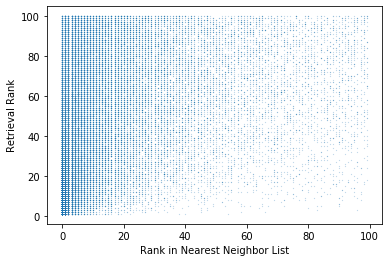

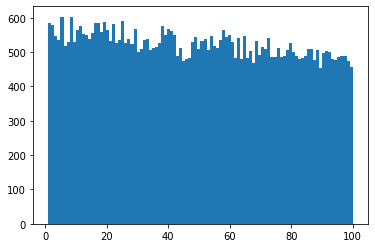

In [402]:
near_rank_pred, reverse_rank_pred = rank_vs_rank(pred_rank_test3)

In [248]:
def normalize_rank_vs_rank(pred_dict):
    near_rank = []
    reverse_rank = []
    for pid, qids in pred_dict.items():
        ranking = [val for key, val in qids.items() if val != 0]
        sorted_ranking = sorted(ranking)
        rank_map = {rank:i+1 for i, rank in enumerate(sorted_ranking)}
        temp_near = [i+1 for i in range(len(ranking))]
        temp_reverse = [rank_map[i] for i in ranking]
        near_rank = near_rank + temp_near
        reverse_rank = reverse_rank + temp_reverse
    plt.xlabel("Normalized Rank in Nearest Neighbor List")
    plt.ylabel("Normalized Retrieval Rank")
    plt.scatter(near_rank, reverse_rank, s=0.8)
    plt.show()
    return near_rank, reverse_rank

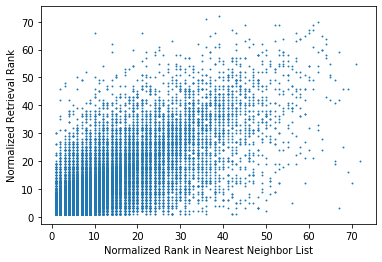

In [405]:
normalized_near_rank_pred, normalized_reverse_rank_pred = normalize_rank_vs_rank(pred_rank_test3)

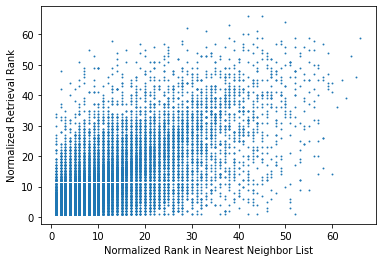

In [404]:
normalized_near_rank_baseline, normalized_reverse_rank_baseline = normalize_rank_vs_rank(forward_baseline_rank_test3)

In [254]:
def compare_normalized_rank(near_rank, reverse_rank, near_rank_base, reverse_rank_base):
    plt.scatter(near_rank, reverse_rank, label="Reverse Ranker", s=0.8)
    plt.scatter(near_rank_base, reverse_rank_base, label="Baseline", s=0.8)
    plt.xlabel("Normalized Rank in Nearest Neighbor List")
    plt.ylabel("Normalized Retrieval Rank")
    plt.legend()
    plt.show()

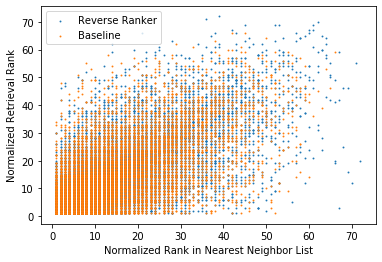

In [406]:
compare_normalized_rank(normalized_near_rank_pred, normalized_reverse_rank_pred, 
                        normalized_near_rank_baseline, normalized_reverse_rank_baseline)

In [ ]:
# Create a new training set with 10000 passages
# Combine the current model with baseline model
pred_rank_test
forward_baseline_rank_test

In [260]:
def combine_new_base(new, baseline):
    combine = {}
    for pid, qids in new.items():
        combine[pid] = {**qids, **baseline[pid]}
    return combine

In [344]:
def total_pos_neg(mydict):
    pos_count = 0
    neg_count = 0
    for pid, qids in mydict.items():
        for qid, rank in qids.items():
            if rank == 0:
                neg_count += 1
            else:
                pos_count += 1
    return neg_count, pos_count

In [267]:
combine_rank_train = combine_new_base(pred_rank_train, forward_baseline_rank_train)

In [346]:
print(total_pos_neg(combine_rank_train))
print(total_pos_neg(pred_rank_train))
print(total_pos_neg(forward_baseline_rank_train))

(1447344, 56704)
(944910, 55090)
(947715, 52285)


In [264]:
def write_dict_to_csv(obj, path):
    with open(path, "w") as file:
        for pid, qids in obj.items():
            for qid, rank in qids.items():
                file.write("{},{},{}\n".format(pid, qid, rank))

In [268]:
write_dict_to_csv(combine_rank_train, RESULT_PATH + "new_training_data_train.csv")

In [343]:
write_dict_to_csv(pred_rank_train, RESULT_PATH + "pred_training_data_train.csv")

In [407]:
sum(top_pred_test3) - sum(top_pred_baseline_test3)

4208

In [ ]:
top_true_train3, top_pred_train3, top_true_baseline_train3, top_pred_baseline_train3, pred_rank_train3

In [422]:
top_true_baseline_test3 == top_true_test3

False